# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
y = "health level" - predicted variable, dependant variable
x = "took the drug" - explanitory variable, independant variable




In [0]:
import random
random.seed(42) # For reproducibility
#dir(random)  # Reminding ourselves what we can do here

In [14]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [19]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500) # spend more time, less likely to buy
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500) #giving MU a slightly higher predictibility | More likely to buy initially but not stay as long
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=150.42273427770718, mobile=False), User(purchased=True, time_on_site=284.06235530493245, mobile=True), User(purchased=True, time_on_site=140.37976895454653, mobile=True), User(purchased=True, time_on_site=49.206452507812216, mobile=True), User(purchased=False, time_on_site=167.81563803588924, mobile=True), User(purchased=False, time_on_site=20.484876517641524, mobile=True), User(purchased=False, time_on_site=167.3540069049869, mobile=True), User(purchased=False, time_on_site=447.75054592529114, mobile=False), User(purchased=True, time_on_site=57.93525538719398, mobile=True), User(purchased=True, time_on_site=292.6494305470663, mobile=True)]


In [20]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,150.422734,False
1,True,284.062355,True
2,True,140.379769,True
3,True,49.206453,True
4,False,167.815638,True


In [21]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.789338167851291,5.836487686604824,7.267690340465448,7.280322437947023,7.733814701629437,7.772242279186957,7.994578759409748,8.373541587279558,9.106003254765849,9.38379653305911,...,582.5363605031145,582.9362427920347,588.8783154469735,590.65747470592,593.8187768755912,597.1381204299279,597.7116143416571,598.547187832115,599.088120104121,599.5766563635087
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,1,1
True,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [22]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,227,238,111,23,37
True,106,133,84,20,21


In [76]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,0.681682,0.641509,0.569231,0.534884,0.637931
True,0.318318,0.358491,0.430769,0.465116,0.362069


In [25]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.704,0.613333
True,0.296,0.386667


In [32]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(user_data['mobile'], [user_data['purchased'],time_bins], 
            rownames=['device'], 
            colnames=["purchased", "time on site"], 
            normalize='index')
# Crosstab looks like a mess 

purchased               False                                        \
time on site (5.196, 124.547] (124.547, 243.304] (243.304, 362.062]   
device                                                                
False                0.148000              0.172              0.144   
True                 0.253333              0.260              0.100   

purchased                                                     True   \
time on site (362.062, 480.819] (480.819, 599.577] (5.196, 124.547]   
device                                                                
False                     0.092              0.148            0.016   
True                      0.000              0.000            0.136   

purchased                                                              \
time on site (124.547, 243.304] (243.304, 362.062] (362.062, 480.819]   
device                                                                  
False                  0.044000              0.072               0.08   
True                   0.162667              0.088               0.00   

purchased                        
time on site (480.819, 599.577]  
device                           
False                     0.084  
True                      0.000

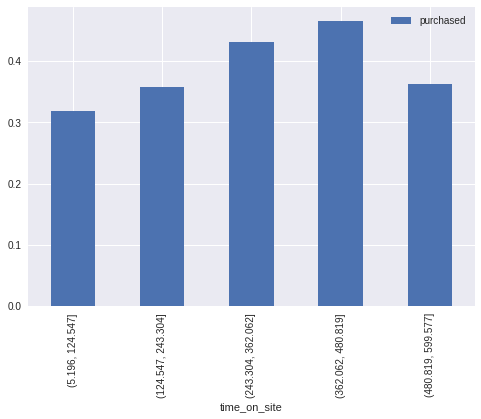

In [42]:
#help(user_data.plot)
#user_data.plot.bar(x='mobile', y='purchased'); # Failed
pd.pivot_table(user_data, values='purchased', index=time_bins).plot.bar(); 
#user_data.hist(bins=20);

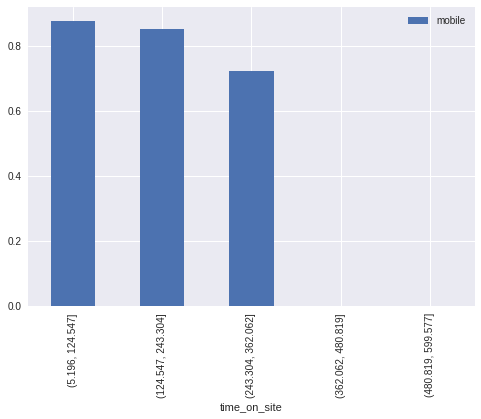

In [44]:
#pd.pivot_table(user_data, values='', index=time_bins).plot.bar(); 

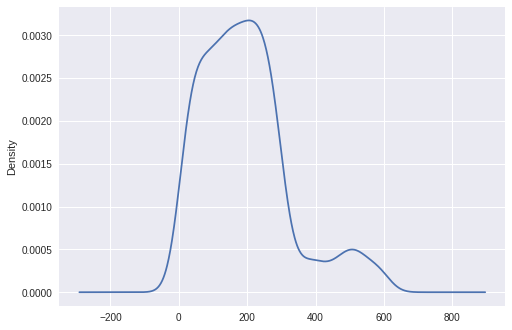

In [40]:

user_data['time_on_site'].plot.density()

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
### ASSIGNMENT:
### Try to figure out which variables are possibly related to each other?
### Which variables may be confounding relationships?


# Load the Data

import pandas as pd
import matplotlib.pyplot as plt
import random
persons_data = pd.read_csv('https://raw.githubusercontent.com/tbradshaw91/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')


In [2]:
# Take a look at the data
# Drop the Unnamed row that doesn't interact with my data

persons_data=persons_data.drop('Unnamed: 0',axis=1) 
persons_data.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [3]:
# Placing the data in bins in order to make it easier to read/work with

workout_bins = pd.cut(persons_data['exercise_time'], 10)  # 10 Bins
weight_bins = pd.cut(persons_data['weight'], 10)  # 10 Bins
age_bins = pd.cut(persons_data['age'], 10)  # 10 Bins

ct = pd.crosstab(age_bins,[weight_bins,workout_bins],
                 rownames=['age'],
                 colnames=['weight','exercise_time'],
                 normalize='index')

# Taking another look at the data
ct.head()

weight         (99.854, 114.6]                                          \
exercise_time     (-0.3, 30.0] (30.0, 60.0] (60.0, 90.0] (90.0, 120.0]   
age                                                                      
(17.938, 24.2]        0.000000     0.014815     0.007407      0.007407   
(24.2, 30.4]          0.000000     0.016529     0.008264      0.008264   
(30.4, 36.6]          0.007692     0.007692     0.000000      0.007692   
(36.6, 42.8]          0.008130     0.000000     0.024390      0.024390   
(42.8, 49.0]          0.008547     0.000000     0.008547      0.000000   

weight                                                                      \
exercise_time  (120.0, 150.0] (150.0, 180.0] (180.0, 210.0] (210.0, 240.0]   
age                                                                          
(17.938, 24.2]       0.014815       0.029630       0.022222       0.014815   
(24.2, 30.4]         0.024793       0.024793       0.008264       0.041322   
(30.4, 36.6]         0.000000       0.023077       0.030769       0.015385   
(36.6, 42.8]         0.016260       0.032520       0.016260       0.032520   
(42.8, 49.0]         0.008547       0.000000       0.025641       0.008547   

weight                                            ...       (231.4, 246.0]  \
exercise_time  (240.0, 270.0] (270.0, 300.0]      ...         (-0.3, 30.0]   
age                                               ...                        
(17.938, 24.2]       0.014815       0.014815      ...             0.014815   
(24.2, 30.4]         0.024793       0.033058      ...             0.000000   
(30.4, 36.6]         0.015385       0.038462      ...             0.000000   
(36.6, 42.8]         0.016260       0.048780      ...             0.008130   
(42.8, 49.0]         0.042735       0.017094      ...             0.025641   

weight                                                                 \
exercise_time  (30.0, 60.0] (60.0, 90.0] (90.0, 120.0] (120.0, 150.0]   
age                                                                     
(17.938, 24.2]     0.007407          0.0           0.0            0.0   
(24.2, 30.4]       0.000000          0.0           0.0            0.0   
(30.4, 36.6]       0.000000          0.0           0.0            0.0   
(36.6, 42.8]       0.000000          0.0           0.0            0.0   
(42.8, 49.0]       0.000000          0.0           0.0            0.0   

weight                                                                      \
exercise_time  (150.0, 180.0] (180.0, 210.0] (210.0, 240.0] (240.0, 270.0]   
age                                                                          
(17.938, 24.2]            0.0            0.0            0.0            0.0   
(24.2, 30.4]              0.0            0.0            0.0            0.0   
(30.4, 36.6]              0.0            0.0            0.0            0.0   
(36.6, 42.8]              0.0            0.0            0.0            0.0   
(42.8, 49.0]              0.0            0.0            0.0            0.0   

weight                         
exercise_time  (270.0, 300.0]  
age                            
(17.938, 24.2]            0.0  
(24.2, 30.4]              0.0  
(30.4, 36.6]              0.0  
(36.6, 42.8]              0.0  
(42.8, 49.0]              0.0  

[5 rows x 100 columns]

**Bar Plot Representing Age vs Weight**

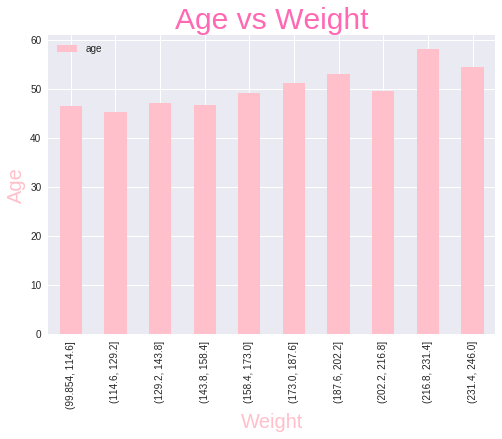

In [26]:
pd.pivot_table(persons_data, values='age', index=weight_bins).plot.bar(color= 'pink'); 
plt.xlabel('Weight', color='pink', size=20)
plt.ylabel('Age', color='pink', size=20)
plt.title('Age vs Weight', color='hotpink', size=30);



This plot shows the relationship between age and weight. Based on the plot, it appears as weight fluctuates based on those 2 variables only. Not a very solid assumption.

**Bar Plot Representing Weight vs Exercise Time**

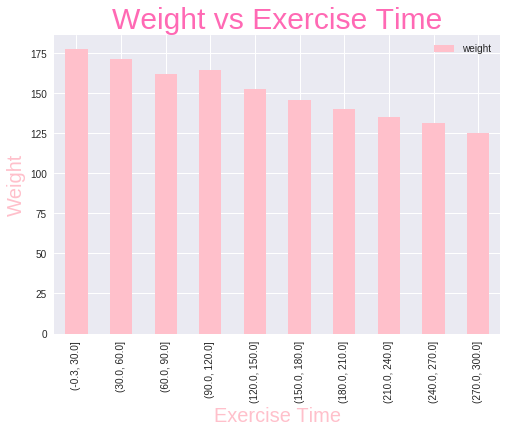

In [29]:
pd.pivot_table(persons_data, values='weight', index=workout_bins).plot.bar(color= 'pink'); 
plt.xlabel('Exercise Time', color='pink', size=20)
plt.ylabel('Weight', color='pink', size=20)
plt.title('Weight vs Exercise Time', color='hotpink', size=30);

This plot shows the relationship between Weight and E.T. Based on this chart, the less amount of time you spend exercising, the higher the weight. 

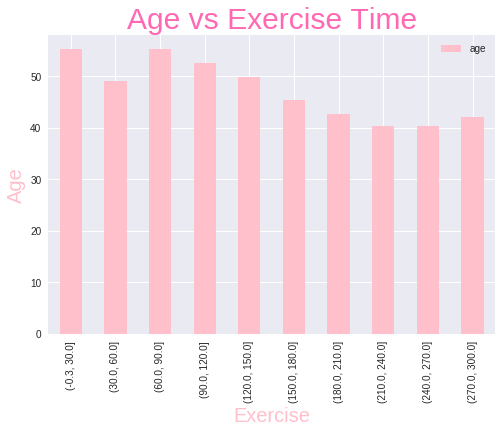

In [30]:
pd.pivot_table(persons_data, values='age', index=workout_bins).plot.bar(color= 'pink'); 
plt.xlabel('Exercise', color='pink', size=20)
plt.ylabel('Age', color='pink', size=20)
plt.title('Age vs Exercise Time', color='hotpink', size=30);

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
**Age is continuous, but in this instance, it would be treated discrete**
**Weight is discrete, although I wonder if it could be seen as continuous when you count water-weight etc**
**Time in general is continuous, I was unsure whether we are treating a set time spent exercising as Discrete or Continuous?**

2.  What are the relationships between the variables?
**They are all related, the more you exercise, the less you weigh, (unless you are bodybuilding--this data did not specify types of workouts.) This is represented in the bar charts above. **
**Typically the higher the age , the less you exercise.  **

3.  Which relationships are "real", and which spurious?
**Spurious Relationships: Age & Weight / Age & Exercise**
**Real Relationship: Weight & Exercise **



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)